6.6 11.4 0 0.05184343
6.6 11.4 0 0.11261802000000001


/home/deadpool/.local/lib/python3.6/site-packages/ipykernel_launcher.py:137: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


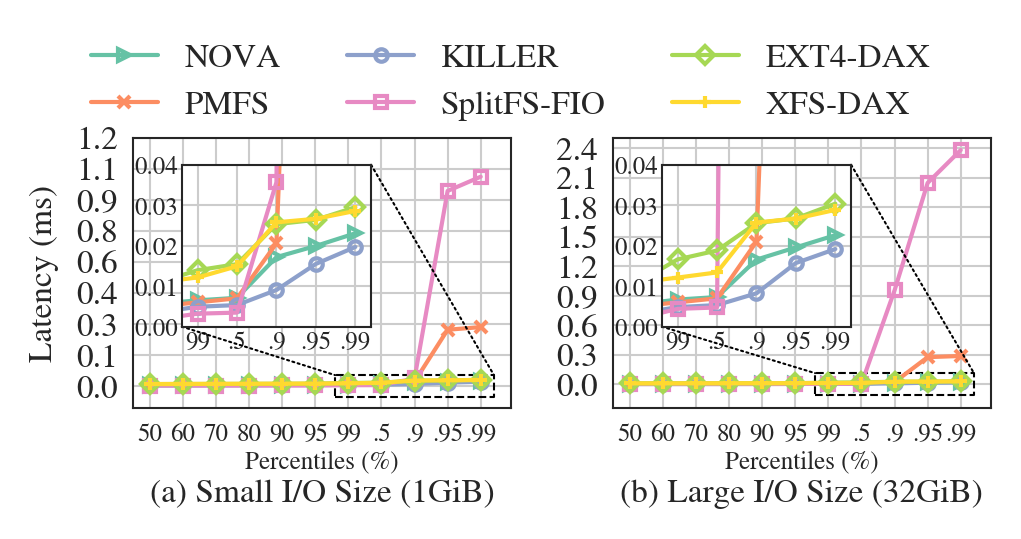

In [5]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.gridspec import GridSpec
from brokenaxes import brokenaxes
from matplotlib.transforms import Bbox
import pandas as pd
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import BboxPatch
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

def zoom_in(axins, x, ys, zone_left, zone_right):
    # 坐标轴的扩展比例（根据实际数据调整）
    x_ratio = 0.1 # x轴显示范围的扩展比例
    y_ratio = 0.1 # y轴显示范围的扩展比例

    # X轴的显示范围
    xlim0 = x[zone_left]-(x[zone_right]-x[zone_left])*x_ratio
    xlim1 = x[zone_right]+(x[zone_right]-x[zone_left])*x_ratio

    stack = []
    for y in ys:
        stack.append(y[zone_left:zone_right])
    y = np.hstack(stack)
    ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
    ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio

    # 调整子坐标系的显示范围
    axins.set_xlim(xlim0, xlim1)
    axins.set_ylim(0, ylim1)
    return (xlim0, xlim1, 0, ylim1)

with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, engine='python')
# print(df)
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(4)))
tail_latency_percentiles = ["50", "60", "70", "80", "90", "95", "99", ".5", ".9", ".95", ".99"]
line_width = 2
# colors = ["#08415c", "#cc2936", "#6b818c", "#f1bf98"]
marks = [">", "x", "o", "s", "D", "+"]
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
tail_latency_percentile = list(range(1, len(tail_latency_percentiles) + 1))
subfig_titles = ["(a) Small I/O Size (1GiB)", "(b) Large I/O Size (32GiB)"]
fsizes = [ 1024, 32768 ]
lines = []
for fsize_idx, fsize in enumerate(fsizes):
    subfig = plt.subplot(1, 2, fsize_idx + 1)
    ax = fig.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
    # box, c1, c2 = mark_inset(ax, axins, loc1=3, loc2=1, fc="none", ec='k', lw=0.5, ls="--", zorder=200)
    # Inset Figure
    axins = ax.inset_axes((0.13, 0.3, 0.5, 0.6))
    ys = []
    for idx, fs in enumerate(fss):
        y = list(df[(df['file_system'] == fs) & (df['file_size'] == fsize)].iloc[:, 2 : 3 + len(tail_latency_percentiles)].iloc[0] / 1000 / 1000)
        axins.plot(tail_latency_percentile, df[(df['file_system'] == fs) & (df['file_size'] == fsize)].iloc[:, 2 : 2 + len(tail_latency_percentiles)].iloc[0] / 1000 / 1000, color=plt.get_cmap('Set2')(idx), markerfacecolor='none', linewidth=1, label=fs, marker=marks[idx], markeredgecolor=plt.get_cmap('Set2')(idx), markersize=3)
        ys.append(y)

    tx0, tx1, ty0, ty1 = zoom_in(axins, tail_latency_percentile, ys, len(tail_latency_percentiles) - 5, len(tail_latency_percentiles) - 1)

    axins.set_ylim(0, 0.02)
    axins.set_yticks(np.linspace(0, 0.04, 5))
    axins.set_yticklabels(np.linspace(0, 0.04, 5), fontsize=6)
    axins.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    axins.set_xticks(np.linspace(len(tail_latency_percentiles) - 4, len(tail_latency_percentiles), 5))
    axins.set_xticklabels(tail_latency_percentiles[-5:], fontsize=6)
    # axins.set_yticklabels(np.linspace(5.5, 6.2, 3), fontsize=6)
    for tick in axins.get_yaxis().get_major_ticks():
        tick.set_pad(1)
    for tick in axins.get_xaxis().get_major_ticks():
        tick.set_pad(1)
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        axins.spines[axis].set_linewidth(lw)
    
    
    # draw a solid rectangle in the inset axes
    ty1 *= 0.05
    ax.plot([tx0, tx1, tx1, tx0, tx0], [-ty1, -ty1, ty1, ty1, -ty1], color='k', lw=0.5, ls="--", zorder=2)

    print(tx0, tx1, ty0, ty1)
    xy = (tx0, ty1)
    xy2 = (tx0, 0)
    con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
            axesA=axins,axesB=ax, lw=0.5, ls=":")
    axins.add_artist(con)

    xy = (tx1, ty1)
    xy2 = (tx1, 0.04)
    con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
            axesA=axins,axesB=ax, lw=0.5, ls=":",)
    axins.add_artist(con)

    # draw
    for idx, fs in enumerate(fss):
        line, = plt.plot(tail_latency_percentile, df[(df['file_system'] == fs) & (df['file_size'] == fsize)].iloc[:, 2 : 2 + len(tail_latency_percentiles)].iloc[0] / 1000 / 1000, color=plt.get_cmap('Set2')(idx), markerfacecolor='none', linewidth=1, label=fs, marker=marks[idx], markeredgecolor=plt.get_cmap('Set2')(idx), markersize=3)
        if fsize_idx == 0:
            lines.append(line)
    
    plt.xticks(tail_latency_percentile, labels=tail_latency_percentiles, fontsize=6)
    if fsize_idx == 0:
        plt.yticks(np.linspace(0, 1.2, 9), fontsize=8)
    else:
        plt.yticks(np.linspace(0, 2.4, 9), fontsize=8)
        
    subfig.text(0.5, -0.2, "Percentiles (%)", ha='center', va='center', fontsize=6, transform=subfig.transAxes)
    plt.xlabel(subfig_titles[fsize_idx], fontsize=8, labelpad=8)
    if fsize_idx == 0:
        plt.ylabel("Latency (ms)", fontsize=8)
    subfig.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

fig.legend(fss, handles=lines, loc='center', ncol=3, bbox_to_anchor=(0.5, 1), fontsize=8)

plt.tight_layout()
plt.savefig("./FIG-IO-TailLatency.pdf", bbox_inches='tight', pad_inches=0)